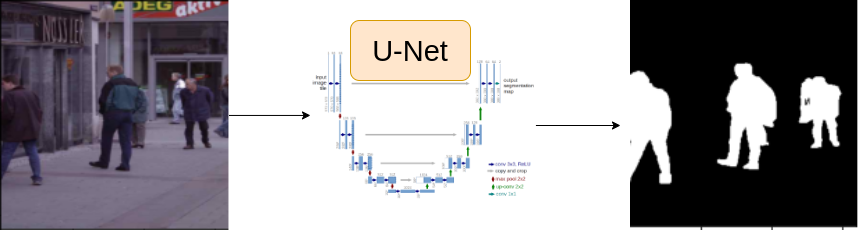

# Some Common Imports

In [27]:
import os
import gc
import sys
import cv2
import torch
import numpy as np 
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [62]:
def mask_to_rgb(mask):
    color_map={
    0: (0, 0, 0),  # Background
    1: (255, 0, 0),  # Class 1
    2: (0, 255, 0),  # Class 2
    3: (0, 0, 255),  # Class 3
    4: (0, 128, 128),  # Class 4
    5: (128, 0, 128),  # Class 5
    }
    if isinstance(mask, torch.Tensor):
        mask = mask.detach().cpu().numpy()
    # Create a new numpy array to hold the RGB mask
    rgb_mask = np.zeros((320, 320, 3), dtype=np.uint8)

    for row in range(320):
        for column in range(320):
            class_index = mask[0][row][column]
            rgb_mask[row][column] = color_map[class_index]

    return rgb_mask

def show_image(image, mask, pred_image=None):
    if pred_image is None:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask_to_rgb(mask))

    else:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1, 2, 0).squeeze(), cmap='gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask_to_rgb(mask))

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(mask_to_rgb(pred_image))

        
def classIndexMask(mask):
    import numpy as np
    from PIL import Image

    # Define a dictionary mapping RGB color values to class indices
    color_to_class = {
      (0, 0, 0): 0,  # Black pixel represents background
      (255, 0, 0): 1,  # Red pixel represents Horse
      (0, 255, 0): 2,  # Green pixel represents Bench
      (0, 0, 255): 3,  # Blue pixel represents Water dispenser
      (0, 128, 128): 4,  # Blue pixel represents Stop sign
      (128, 0, 128): 5,  # Blue pixel represents Dust bin
    }

    # Load a masked image in RGB format
    mask_image = Image.open(mask)
    mask_image = mask_image.resize((320, 320))

    # Convert the RGB image to a numpy array
    mask_array = np.array(mask_image)

    # Create a new numpy array to hold the class index mask
    class_indices = np.zeros((mask_array.shape[0], mask_array.shape[1]), dtype=np.uint8)

    # Iterate over each RGB color value and map it to a class index
    for color, class_idx in color_to_class.items():
      # Find the indices in the numpy array where the RGB color value matches the dictionary key
      color_indices = np.where(np.all(mask_array == color, axis=-1))
      # Assign the corresponding class index to the pixels at those indices
      class_indices[color_indices] = class_idx
    return class_indices



# Task : 2 Setup Configurations

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
sys.path.append('/content/drive/MyDrive/Deep learning project final/')
DEVICE = 'cpu'
device = DEVICE
EPOCHS = 50
LR = 0.003
IMAGE_HEIGHT = 320
IMAGE_WIDTH = 320
BATCH_SIZE = 8
ENCODER = 'efficientnet-b7'
WEIGHTS = 'imagenet'

In [31]:
df = pd.read_csv('/content/drive/MyDrive/Deep learning project final/train.csv')
df.head()

,masks,images
0,white masked images\0.png,training samples\0.jpg
1,white masked images\1.png,training samples\1.jpg
2,white masked images\10.png,training samples\10.jpg
3,white masked images\100.png,training samples\100.jpg
4,white masked images\101.png,training samples\101.jpg


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   masks   145 non-null    object
 1   images  145 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


Image Size (320, 320, 3)
Mask Size (320, 320, 3)


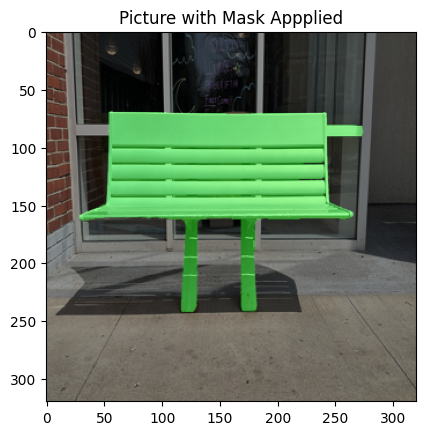

In [33]:
row = df.iloc[39]
dir = "/content/drive/MyDrive/Deep learning project final/"
image_path = dir+row.images.replace('\\', '/')
mask_path = dir+row.masks.replace('\\', '/')
img = Image.open(image_path)
mask = Image.open(mask_path)
mask_np = np.array(mask)
mask_np_gray = cv2.cvtColor(mask_np, cv2.COLOR_RGB2GRAY).copy()

new_size = (320, 320)
img = img.resize(new_size)
mask = mask.resize(new_size)

print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)
plt.imshow(img)
plt.imshow(mask, alpha=0.4)
plt.title('Picture with Mask Appplied')
plt.show()

In [34]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 4 : Create Custom Dataset 

In [35]:
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import transforms

In [36]:
class SegmentationDataset(Dataset):
    
    def __init__(self, df):
        
        self.df=df
        self.transforms = transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT), antialias=True)

        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self ,idx):
        row = self.df.iloc[idx]
        dir = "/content/drive/MyDrive/Deep learning project final/"
        image_path = dir+row.images.replace('\\', '/')
        mask_path = dir+row.masks.replace('\\', '/')
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = classIndexMask(mask_path)
        # print(mask.shape)
        mask =np.expand_dims(mask ,axis=-1)#(h,w,1)
        # print(mask.shape)
        
        #(h,w,c) -> (c,h,w)
        image = np.transpose(image ,(2,0,1)).astype(np.float32)
        mask = np.transpose(mask ,(2,0,1)).astype(np.float32)
        
        original_image = self.transforms(torch.Tensor(image))
        original_image = original_image/255.0
        
        
        return original_image, torch.Tensor(mask)


In [37]:
trainset = SegmentationDataset(train_df)
validset = SegmentationDataset(valid_df)


In [38]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 116
Size of Validset : 29


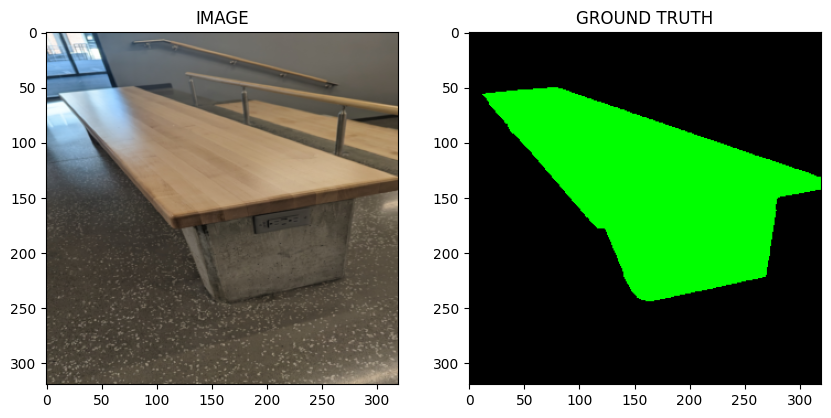

In [39]:
idx = 4
image, mask = trainset[idx]
show_image(image, mask)

# Task 5 : Load dataset into batches

In [40]:
from torch.utils.data import DataLoader


In [41]:
trainloader = DataLoader(trainset , batch_size =BATCH_SIZE , shuffle =True )
validloader = DataLoader(validset , batch_size =BATCH_SIZE  )

In [42]:
print(f"total no,of batches in trainloader: {len(trainloader)}")
print(f"total no,of batches in validloader: {len(validloader)}")

total no,of batches in trainloader: 15
total no,of batches in validloader: 4


In [43]:
for image , mask in trainloader:
    break
print (f'One batch image shape: {image.shape}')
print (f'One batch image shape: {mask.shape}')

One batch image shape: torch.Size([8, 3, 320, 320])
One batch image shape: torch.Size([8, 1, 320, 320])


# Task 6 : Create Segmentation Model

In [44]:
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
from torch import nn 
import segmentation_models_pytorch as smp

# Task 7 : Create Train and Validation Function 

In [46]:
class SegmentationModel (nn.Module):
    def __init__(self):
        super (SegmentationModel , self).__init__()

        self.arc = smp.Unet(
            encoder_name= ENCODER ,
            encoder_weights=  WEIGHTS ,
            in_channels= 3 ,
            classes=  6,
            activation = 'softmax'
        )
        
        
    def forward(self, images, masks=None):
        logits = self.arc(images)

        if masks is not None:
            masks = masks.squeeze(1) # remove the channel dimension
            criterion = nn.CrossEntropyLoss()
            loss = criterion(logits, masks)
            return logits, loss

        return logits

In [47]:
model = SegmentationModel()
model.to('cpu')

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            64, 16, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            16, 64, kernel_size=(1, 1), stride=(1, 1)
            (static_padding):

In [48]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0
    tk0 = tqdm(data_loader, total=len(data_loader))
    for i, (images, masks) in enumerate(tk0):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        masks = masks.long()  # Convert to integer tensor
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.mean().backward()
        optimizer.step()
        total_loss += loss.item()
        tk0.set_postfix(loss=total_loss/(i+1))
    return total_loss / len(data_loader)

def eval_fn(data_loader, model):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        tk0 = tqdm(data_loader, total=len(data_loader))
        for i, (images, masks) in enumerate(tk0):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            masks = masks.long()  # Convert to integer tensor
            logits, loss = model(images, masks)
            total_loss += loss.item()
            tk0.set_postfix(loss=total_loss/(i+1))
    return total_loss / len(data_loader)


# Task 8 : Train Model

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [188]:
best_valid_loss = 1000
for i in range(50):
    train_loss = train_fn(trainloader , model , optimizer)
    valid_loss = eval_fn(validloader , model )

    if valid_loss< best_valid_loss :
        torch.save(model.state_dict(), '/content/drive/MyDrive/Deep learning project final/bestModelAlpha.pt')
        print ("SAVED")
        best_valid_loss = valid_loss
    print(f"Epoch : {i+1} train_loss :{train_loss} valid_loss :{valid_loss}" )

  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
100%|██████████| 4/4 [00:05<00:00,  1.41s/it, loss=1.59]


SAVED
Epoch : 1 train_loss :1.6034130016962687 valid_loss :1.5881323516368866


100%|██████████| 4/4 [00:05<00:00,  1.41s/it, loss=1.26]


SAVED
Epoch : 2 train_loss :1.3194230159123739 valid_loss :1.2572553157806396


100%|██████████| 4/4 [00:05<00:00,  1.42s/it, loss=1.33]


Epoch : 3 train_loss :1.2396344900131226 valid_loss :1.3345473110675812


100%|██████████| 4/4 [00:06<00:00,  1.54s/it, loss=1.28]


Epoch : 4 train_loss :1.2049914280573526 valid_loss :1.2775940895080566


100%|██████████| 4/4 [00:06<00:00,  1.72s/it, loss=1.22]


SAVED
Epoch : 5 train_loss :1.1886383771896363 valid_loss :1.2231382727622986


100%|██████████| 4/4 [00:06<00:00,  1.74s/it, loss=1.33]


Epoch : 6 train_loss :1.1835835297902426 valid_loss :1.3306154310703278


100%|██████████| 4/4 [00:06<00:00,  1.70s/it, loss=1.38]


Epoch : 7 train_loss :1.1789668401082356 valid_loss :1.3751833140850067


100%|██████████| 4/4 [00:06<00:00,  1.73s/it, loss=1.32]


Epoch : 8 train_loss :1.1736658732096354 valid_loss :1.3171062767505646


100%|██████████| 4/4 [00:06<00:00,  1.71s/it, loss=1.18]


SAVED
Epoch : 9 train_loss :1.1541635831197103 valid_loss :1.183028131723404


100%|██████████| 4/4 [00:06<00:00,  1.69s/it, loss=1.29]


Epoch : 10 train_loss :1.1457147121429443 valid_loss :1.2852931320667267


100%|██████████| 4/4 [00:06<00:00,  1.67s/it, loss=1.24]


Epoch : 11 train_loss :1.1346762657165528 valid_loss :1.2365861535072327


100%|██████████| 4/4 [00:06<00:00,  1.56s/it, loss=1.26]


Epoch : 12 train_loss :1.1313737948735556 valid_loss :1.255614548921585


100%|██████████| 4/4 [00:05<00:00,  1.45s/it, loss=1.45]


Epoch : 13 train_loss :1.1229537010192872 valid_loss :1.4488982856273651


100%|██████████| 4/4 [00:05<00:00,  1.44s/it, loss=1.29]


Epoch : 14 train_loss :1.1225037813186645 valid_loss :1.2851043343544006


100%|██████████| 4/4 [00:05<00:00,  1.43s/it, loss=1.14]


SAVED
Epoch : 15 train_loss :1.10863090356191 valid_loss :1.137472540140152


100%|██████████| 4/4 [00:05<00:00,  1.43s/it, loss=1.18]


Epoch : 16 train_loss :1.114794119199117 valid_loss :1.1824742257595062


100%|██████████| 4/4 [00:05<00:00,  1.43s/it, loss=1.15]


Epoch : 17 train_loss :1.1004092931747436 valid_loss :1.15180903673172


100%|██████████| 4/4 [00:05<00:00,  1.44s/it, loss=1.13]


SAVED
Epoch : 18 train_loss :1.0899216810862222 valid_loss :1.129537582397461


100%|██████████| 4/4 [00:05<00:00,  1.43s/it, loss=1.12]


SAVED
Epoch : 19 train_loss :1.0858295440673829 valid_loss :1.1234999597072601


100%|██████████| 4/4 [00:05<00:00,  1.43s/it, loss=1.29]


Epoch : 20 train_loss :1.0857597907384238 valid_loss :1.286092847585678


100%|██████████| 4/4 [00:06<00:00,  1.57s/it, loss=1.14]


Epoch : 21 train_loss :1.088051692644755 valid_loss :1.1441133320331573


100%|██████████| 4/4 [00:06<00:00,  1.63s/it, loss=1.1]


SAVED
Epoch : 22 train_loss :1.0860355615615844 valid_loss :1.097275197505951


100%|██████████| 4/4 [00:06<00:00,  1.59s/it, loss=1.11]


Epoch : 23 train_loss :1.0906913201014201 valid_loss :1.1052009463310242


100%|██████████| 4/4 [00:06<00:00,  1.71s/it, loss=1.13]


Epoch : 24 train_loss :1.0853729089101156 valid_loss :1.1257979273796082


100%|██████████| 4/4 [00:06<00:00,  1.71s/it, loss=1.12]


Epoch : 25 train_loss :1.0838740666707356 valid_loss :1.1181759238243103


100%|██████████| 4/4 [00:06<00:00,  1.73s/it, loss=1.13]


Epoch : 26 train_loss :1.0830346743265789 valid_loss :1.1279902160167694


100%|██████████| 4/4 [00:06<00:00,  1.70s/it, loss=1.12]


Epoch : 27 train_loss :1.0804519255956013 valid_loss :1.1170459389686584


100%|██████████| 4/4 [00:06<00:00,  1.57s/it, loss=1.07]


SAVED
Epoch : 28 train_loss :1.078292997678121 valid_loss :1.0749897062778473


100%|██████████| 4/4 [00:06<00:00,  1.55s/it, loss=1.09]


Epoch : 29 train_loss :1.0782205581665039 valid_loss :1.0901257395744324


100%|██████████| 4/4 [00:05<00:00,  1.47s/it, loss=1.09]


Epoch : 30 train_loss :1.07408607006073 valid_loss :1.089451938867569


100%|██████████| 4/4 [00:05<00:00,  1.44s/it, loss=1.08]


Epoch : 31 train_loss :1.0750703414281209 valid_loss :1.0837150812149048


100%|██████████| 4/4 [00:05<00:00,  1.42s/it, loss=1.08]


Epoch : 32 train_loss :1.071138334274292 valid_loss :1.0793347358703613


100%|██████████| 4/4 [00:05<00:00,  1.43s/it, loss=1.08]


Epoch : 33 train_loss :1.070861268043518 valid_loss :1.0762137472629547


100%|██████████| 4/4 [00:05<00:00,  1.43s/it, loss=1.08]


Epoch : 34 train_loss :1.0707567532857258 valid_loss :1.0786377489566803


100%|██████████| 4/4 [00:06<00:00,  1.57s/it, loss=1.08]


Epoch : 35 train_loss :1.0724209467569987 valid_loss :1.0756089687347412


100%|██████████| 4/4 [00:06<00:00,  1.71s/it, loss=1.11]


Epoch : 36 train_loss :1.0761045932769775 valid_loss :1.1083437204360962


100%|██████████| 4/4 [00:06<00:00,  1.70s/it, loss=1.11]


Epoch : 37 train_loss :1.0737617413202922 valid_loss :1.1089155673980713


100%|██████████| 4/4 [00:06<00:00,  1.68s/it, loss=1.08]


Epoch : 38 train_loss :1.0727167129516602 valid_loss :1.0813837945461273


100%|██████████| 4/4 [00:06<00:00,  1.72s/it, loss=1.07]


SAVED
Epoch : 39 train_loss :1.0697058359781901 valid_loss :1.0749684870243073


100%|██████████| 4/4 [00:06<00:00,  1.71s/it, loss=1.09]


Epoch : 40 train_loss :1.0716516653696695 valid_loss :1.0882715284824371


100%|██████████| 4/4 [00:06<00:00,  1.58s/it, loss=1.09]


Epoch : 41 train_loss :1.075818943977356 valid_loss :1.0852640569210052


100%|██████████| 4/4 [00:05<00:00,  1.49s/it, loss=1.09]


Epoch : 42 train_loss :1.0713920672734578 valid_loss :1.0862955749034882


100%|██████████| 4/4 [00:05<00:00,  1.42s/it, loss=1.1]


Epoch : 43 train_loss :1.0685074249903361 valid_loss :1.0997640788555145


100%|██████████| 4/4 [00:05<00:00,  1.41s/it, loss=1.1]


Epoch : 44 train_loss :1.072719113032023 valid_loss :1.0994274616241455


100%|██████████| 4/4 [00:05<00:00,  1.42s/it, loss=1.09]


Epoch : 45 train_loss :1.0692061026891073 valid_loss :1.092139720916748


100%|██████████| 4/4 [00:05<00:00,  1.46s/it, loss=1.14]


Epoch : 46 train_loss :1.0705845753351848 valid_loss :1.1387883722782135


100%|██████████| 4/4 [00:06<00:00,  1.56s/it, loss=1.1]


Epoch : 47 train_loss :1.0663089911142984 valid_loss :1.0993375480175018


100%|██████████| 4/4 [00:06<00:00,  1.70s/it, loss=1.1]


Epoch : 48 train_loss :1.0599206844965616 valid_loss :1.1000751554965973


100%|██████████| 4/4 [00:06<00:00,  1.69s/it, loss=1.09]


Epoch : 49 train_loss :1.0598785241444906 valid_loss :1.0897131264209747


100%|██████████| 4/4 [00:07<00:00,  1.75s/it, loss=1.08]

Epoch : 50 train_loss :1.0604275782903037 valid_loss :1.0809840559959412







\




sdsdsd



sdsdds# Task 9 : Inference

In [50]:

# model.load_state_dict(torch.load(r'/content/drive/MyDrive/Deep learning project final/bestModelAlpha.pt'))
model.load_state_dict(torch.load(r'/content/drive/MyDrive/Deep learning project final/bestModelAlpha.pt', map_location=torch.device('cpu')))


<All keys matched successfully>

In [102]:
idx = 19
image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze (0)) #(C, H, W) -> (1, C, H, W)
print(logits_mask.shape)

torch.Size([1, 6, 320, 320])


In [103]:
pred_mask_prob = torch.softmax(logits_mask, dim=1)  # (batch_size, num_classes, height, width)
_, pred_mask = torch.max(pred_mask_prob, dim=1)  # (batch_size, height, width)


In [104]:
pred_mask.squeeze(0).shape

torch.Size([320, 320])

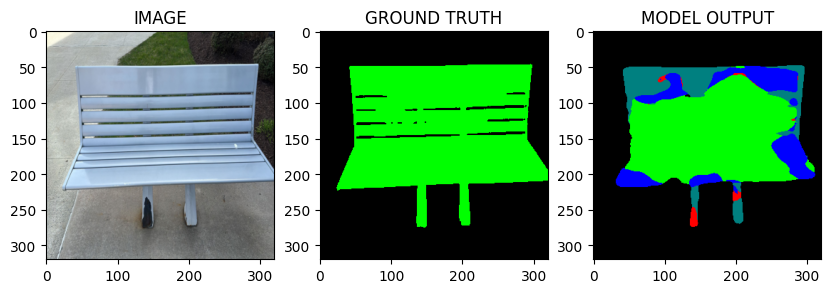

In [105]:
show_image(image, mask, pred_mask)

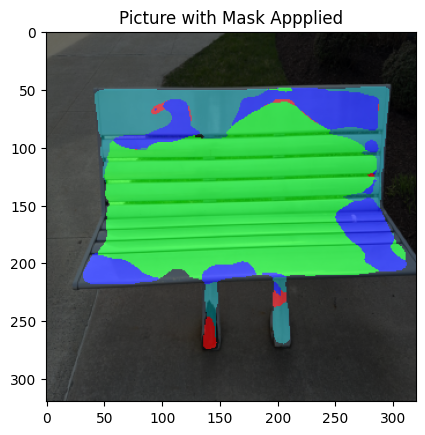

In [106]:
rgb_mask = mask_to_rgb(pred_mask)
plt.imshow(image.permute(1,2,0))
plt.imshow(rgb_mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()